### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集

In [1]:
# 将matplotlib的图表直接嵌入到Notebook之中,或者使用指定的界面库显示图表

%matplotlib inline

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

FILENAME = "mnist.pkl.gz"

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid),
     _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)


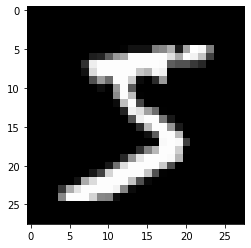

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)
# 50000个样本，每个图像是28*28*1

In [16]:
x_train[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

注意数据需转换成tensor才能参与后续建模训练


In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor,
                                         (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [6]:
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np


# 继承nn.Module
class Mnist_NN(nn.Module):
    # 构造函数
    def __init__(self):
        # 调用nn.Module的构造函数
        super().__init__()
        self.hidden1 = nn.Linear(784, 128) # 隐层1
        self.hidden2 = nn.Linear(128, 256) # 隐层2
        self.out = nn.Linear(256, 10) # 输出层

    # 前向传播
    def forward(self, x):
        # import torch.nn.functional as F
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [7]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [8]:
for name, parameter in net.named_parameters():
    print(name, parameter, parameter.size())

hidden1.weight Parameter containing:
tensor([[-0.0107,  0.0176,  0.0235,  ...,  0.0040, -0.0234,  0.0087],
        [ 0.0177, -0.0273,  0.0112,  ..., -0.0134,  0.0282, -0.0013],
        [ 0.0139, -0.0125,  0.0143,  ..., -0.0239,  0.0263, -0.0089],
        ...,
        [-0.0204,  0.0160,  0.0061,  ..., -0.0239, -0.0082, -0.0247],
        [ 0.0070, -0.0266, -0.0093,  ..., -0.0144,  0.0022,  0.0010],
        [ 0.0227,  0.0055,  0.0275,  ..., -0.0272,  0.0136, -0.0164]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-0.0097,  0.0237,  0.0018, -0.0330, -0.0280, -0.0191, -0.0255,  0.0288,
         0.0225,  0.0101, -0.0063, -0.0276,  0.0091,  0.0075, -0.0313,  0.0057,
        -0.0356, -0.0265,  0.0286, -0.0057, -0.0100, -0.0276,  0.0178, -0.0170,
        -0.0174,  0.0337,  0.0259, -0.0143,  0.0314,  0.0331,  0.0341,  0.0189,
        -0.0315, -0.0170,  0.0237,  0.0156, -0.0345,  0.0154,  0.0197,  0.0305,
         0.0349, -0.0326,  0.0193, -0.0336, 

### 使用TensorDataset和DataLoader来简化

In [9]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [11]:
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [12]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [10]:
# 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
# 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:' + str(step), '验证集损失：' + str(val_loss))

### 开始训练！

In [15]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
bs = 64
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
loss_func = F.cross_entropy # 交叉熵损失函数
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：2.2809557510375975
当前step:1 验证集损失：2.2500623081207274
当前step:2 验证集损失：2.202859774017334
当前step:3 验证集损失：2.123643782043457
当前step:4 验证集损失：1.9911612365722657
当前step:5 验证集损失：1.7912375587463378
当前step:6 验证集损失：1.5452837438583373
当前step:7 验证集损失：1.3032891147613526
当前step:8 验证集损失：1.1027766933441163
当前step:9 验证集损失：0.949706922531128
当前step:10 验证集损失：0.8340907591819763
当前step:11 验证集损失：0.7464724873542785
当前step:12 验证集损失：0.6767623687744141
当前step:13 验证集损失：0.622122283744812
当前step:14 验证集损失：0.5775999296188354
当前step:15 验证集损失：0.5417200242042541
当前step:16 验证集损失：0.5122299160003662
当前step:17 验证集损失：0.4875089702606201
当前step:18 验证集损失：0.46718254098892215
当前step:19 验证集损失：0.4494625943660736
当前step:20 验证集损失：0.4347919206619263
当前step:21 验证集损失：0.4215654832363129
当前step:22 验证集损失：0.41056136293411255
当前step:23 验证集损失：0.4001917915582657
当前step:24 验证集损失：0.39120743613243103


In [18]:
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [19]:
y_train

tensor([5, 0, 4,  ..., 8, 4, 8])

In [20]:
x_valid

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [21]:
y_valid

tensor([3, 8, 6,  ..., 5, 6, 8])

In [28]:
predicted = model(x_train[:]).data.numpy()
res=np.argmax(predicted, axis=1)
predicted[0]

array([ 2.2787054, -4.0775065,  0.7874506,  5.3936048, -4.6854734,
        4.3960814, -2.1894646, -0.6167434,  2.0032115, -0.9790252],
      dtype=float32)

In [27]:
res

array([3, 0, 4, ..., 8, 4, 8], dtype=int64)

<Figure size 432x288 with 0 Axes>

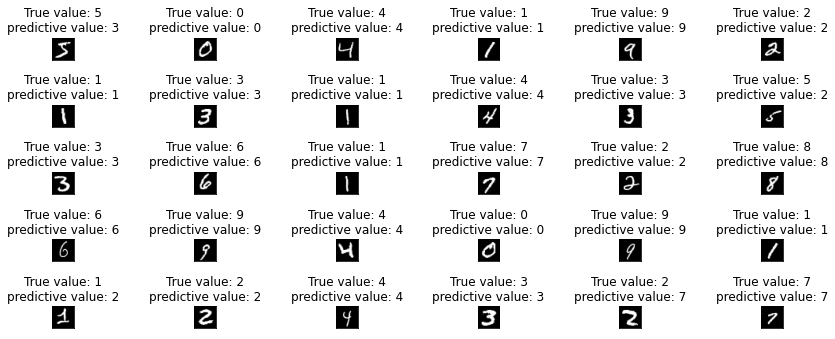

In [69]:
import matplotlib.pyplot as plt

fig=plt.figure()
plt.figure(figsize=(12,5))

for i in range(30):
    plt.subplot(5,6,i+1)
    plt.tight_layout()
    plt.imshow(x_train[i].reshape((28, 28)), cmap="gray")
    plt.title("True value: {}\npredictive value: {}".format(y_train[i],res[i])) 
    plt.xticks([]) 
    plt.yticks([])

In [40]:
pic_data[2]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.2500, 0.9961, 0.9961, 0.9961, 0.7461, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [52]:
pic_data[2].shape

torch.Size([784])